In [20]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from mpl_toolkits.mplot3d import Axes3D

path = '../output_data/'

,O1,O2,O3,O4,O5,O6,O7,O8,sample_id
sample,,,,,,,,,
3,20.0,9.0,11.0,10.0,17.0,29.0,2.0,2.0,NaN
9,18.0,20.0,34.0,5.0,4.0,13.0,3.0,3.0,NaN
12,0.0,17.0,28.0,15.0,11.0,19.0,4.0,6.0,NaN
17,60.0,2.0,11.0,3.0,3.0,16.0,4.0,1.0,NaN
20,11.0,3.0,13.0,5.0,23.0,35.0,8.0,2.0,NaN


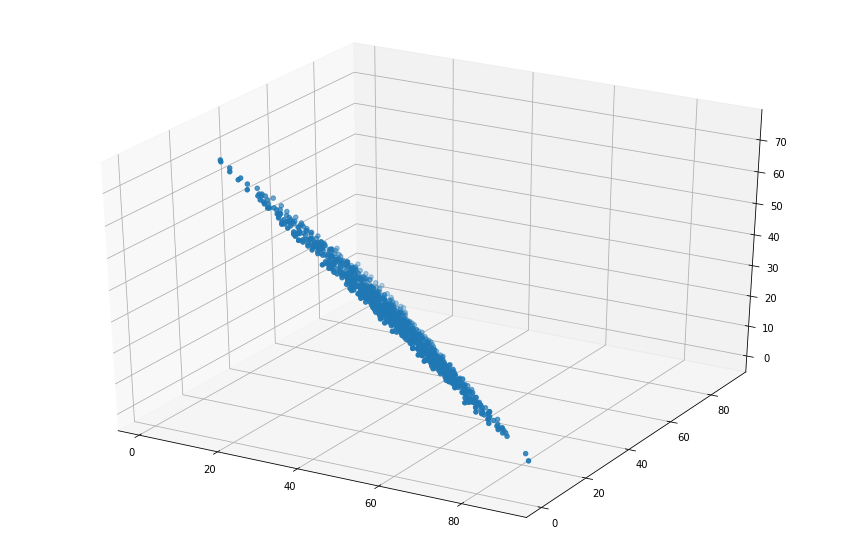

In [23]:
# with pd.HDFStore(path + 'X0a_ffh.h5') as store:
#     opd = store.select('dat_0')
with pd.HDFStore(path + 'X0a_ffh.h5') as store:
    opd = store.select('dat_0',  where='eps=0.02 & phi=0.5')
opd.index = opd.index.droplevel(['eps', 'phi', 'ffh', 'test'])
opinions = opd.xs(level=1, key='opinions')
dfN = opinions
dfN_vis = pd.DataFrame(index=dfN.index)
dfN_vis['x'] = dfN['O1'] + dfN['O2'] + dfN['O3']
dfN_vis['y'] = dfN['O4'] + dfN['O5'] + dfN['O6']
dfN_vis['z'] = dfN['O7'] + dfN['O8']

fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs=dfN_vis[['x']], ys=dfN_vis[['y']], zs=dfN_vis['z'])
dfN.head()
# opd.index = opd.index.droplevel(['eps', 'phi', 'ffh', 'test'])
# opinions = opd.xs(level=1, key='opinions')
# dfN = pd.DataFrame(index=opinions.index)
# for i in range(8):
#     dfN[f'O{i+1}'] = (opinions==i).sum(axis=1)
# dfN_vis = pd.DataFrame(index=dfN.index)
# dfN_vis['x'] = dfN['O1'] + dfN['O2'] + dfN['O3']
# dfN_vis['y'] = dfN['O4'] + dfN['O5'] + dfN['O6']
# dfN_vis['z'] = dfN['O7'] + dfN['O8']

# fig = plt.figure(figsize=(15, 10))
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(xs=dfN_vis[['x']], ys=dfN_vis[['y']], zs=dfN_vis['z'])
# dfN.head()

In [24]:
with pd.HDFStore(path + 'X0a_ffh.h5') as store:
    trj = store.select('dat_1', where='eps=0.02 & phi=0.5')
trj.index = trj.index.droplevel(['eps', 'phi', 'ffh', 'test'])
trj.head()

C             G   G_alpha           K_c  \
sample tstep                                                       
3      0.00   7.797921e+14  1.155583e+06  0.680798  3.119284e+14   
       0.05   7.819595e+14  1.155054e+06  0.680404  3.121257e+14   
       0.10   7.841267e+14  1.154524e+06  0.680010  3.118944e+14   
       0.15   7.862925e+14  1.153994e+06  0.679616  3.115291e+14   
       0.20   7.884570e+14  1.153465e+06  0.679221  3.112833e+14   

                  K_c_cost           K_d      K_d_cost             L    O1  \
sample tstep                                                                 
3      0.00   1.962911e+13  2.041857e+15  1.521939e+14  3.288421e+09  20.0   
       0.05   1.966541e+13  2.041394e+15  1.521508e+14  3.288421e+09  21.0   
       0.10   1.967091e+13  2.041398e+15  1.521409e+14  3.288421e+09  21.0   
       0.15   1.967956e+13  2.041405e+15  1.521254e+14  3.288421e+09  21.0   
       0.20   1.968536e+13  2.041409e+15  1.521149e+14  3.288421e+09  21.0   

               O2    ...        d8  decision state       i_c       r_c  \
sample tstep         ...                                                 
3      0.00   9.0    ...      0.00             0.0  0.490172  0.062928   
       0.05   8.0    ...      0.02             0.1  0.099213  0.063005   
       0.10   8.0    ...      0.02             0.1  0.099210  0.063069   
       0.15   8.0    ...      0.02             0.1  0.099204  0.063171   
       0.20   7.0    ...      0.02             0.1  0.099200  0.063239   

               r_c_dot       r_d   r_d_dot  time           wage  sample_id  
sample tstep                                                                
3      0.00   0.000000  0.074537  0.000000  0.00  104501.829294        NaN  
       0.05   0.001518  0.074533 -0.000099  0.05  104497.668835        NaN  
       0.10   0.001631  0.074528 -0.000119  0.10  104495.033689        NaN  
       0.15   0.001605  0.074520 -0.000124  0.15  104490.832130        NaN  
       0.20   0.001552  0.074515 -0.000120  0.20  104487.976706        NaN  

[5 rows x 50 columns]

In [25]:
cond = pd.DataFrame(index=trj.index)
cond['a'] = trj['K_c']/trj['K_d'] - 0.15276374882897656
cond['b'] = trj['i_c']
cond['c'] = trj['r_c']
cond.head()

a         b         c
sample tstep                              
3      0.00   0.000003  0.490172  0.062928
       0.05   0.000135  0.099213  0.063005
       0.10   0.000021  0.099210  0.063069
       0.15  -0.000158  0.099204  0.063171
       0.20  -0.000279  0.099200  0.063239

In [26]:
t_max=9

# calculate point distance
cond['d'] = np.sqrt((cond['a'])**2)

# sum over point distance for each trajectory
dfN['distance'] = cond['d'].unstack('sample').loc[:t_max].sum(axis=0)

# map distances to interval (0,1]
dfN['inv_distance'] = 1./(1. + dfN['distance'])

# use 1/distance as weight
dfN['weight'] = 1./cond['d'].unstack('sample').loc[:t_max].sum(axis=0)
dfN['weight'] = dfN['weight']/sum(dfN['weight'].values)

for s in dfN.index.values:
    cond.loc[s, 'inv_distance'] = dfN.loc[s, 'inv_distance']
dfN['weight'].sum()
dfN.head()

,O1,O2,O3,O4,O5,O6,O7,O8,sample_id,distance,inv_distance,weight
sample,,,,,,,,,,,,
3,20.0,9.0,11.0,10.0,17.0,29.0,2.0,2.0,NaN,0.909015,0.523830,0.004107
9,18.0,20.0,34.0,5.0,4.0,13.0,3.0,3.0,NaN,6.321430,0.136585,0.000591
12,0.0,17.0,28.0,15.0,11.0,19.0,4.0,6.0,NaN,42.285943,0.023102,0.000088
17,60.0,2.0,11.0,3.0,3.0,16.0,4.0,1.0,NaN,3.739671,0.210985,0.000998
20,11.0,3.0,13.0,5.0,23.0,35.0,8.0,2.0,NaN,0.961460,0.509824,0.003883


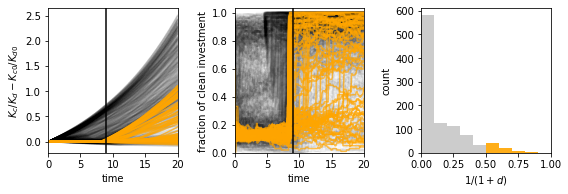

In [27]:
from collections import Counter

fig, axes = plt.subplots(ncols=3, figsize=(8, 2.8))

def plot_cond(df, c, ax, t_max, thresh=0.5):
    tmp = df
    tmp1 = tmp[[c]].loc[tmp['inv_distance']<thresh]
    tmp2 = tmp[[c]].loc[tmp['inv_distance']>thresh]
    try:
        tmp1.unstack('sample').loc[:t_max].plot(ax=ax, alpha=.03, legend=False, color=['k'])
    except TypeError:
        print('no data')
    try:
        tmp2.unstack('sample').loc[:t_max].plot(ax=ax, legend=False, alpha=.7, color=['orange'])
    except TypeError:
        print('no data')
    
thresh=0.5

plot_cond(cond, 'a', axes[0], 20, thresh=thresh)
plot_cond(cond, 'b', axes[1], 20, thresh=thresh)

try:
    dfN['inv_distance'].loc[dfN['inv_distance']>thresh].plot.hist(ax=axes[2], color=['orange'], alpha=0.9, bins=0.1*np.arange(5,11))
    dfN['inv_distance'].loc[dfN['inv_distance']<thresh].plot.hist(ax=axes[2], color=['k'], alpha=0.2, bins=0.1*np.arange(0,6))
except TypeError:
    print('no data')

#plt.yscale('log', nonposy='clip')

# dfN['weight'].loc[dfN['weight']<thresh].plot(ax=axes[2], style='.', alpha=0.3, color='k')
# dfN['weight'].loc[dfN['weight']>thresh].plot(ax=axes[2], style='.', color='orange')

for ax in axes[:2]:
    ax.set_xlim([0,20])
    ax.set_xlabel('time')
    ax.axvline(t_max, color='k')

axes[0].set_ylabel(r'$K_c/K_d - K_{c0}/K_{d0}$')
axes[1].set_ylabel('fraction of clean investment')
axes[1].set_ylim((0,1.03))
axes[2].set_ylabel('count')
axes[2].set_xlabel(r'$1/(1+d)$')
axes[2].set_xlim([0,1])

fig.tight_layout()
fig.savefig('initial_condition_sampling.pdf')

In [31]:
oNames = [f'O{i+1}' for i in range(8)]

dfN_norm = pd.DataFrame(index=dfN.index, columns=dfN.columns)

for i in range(len(dfN)):
    dfN_norm.loc[i, oNames] = dfN.loc[i, oNames] * dfN['weight'][i]
dfN_norm['weight'] = dfN['weight']
print([round(x) for x in dfN_norm.sum()])
print(sum([round(x) for x in dfN_norm[oNames].sum()]))
print(dfN_norm.weight.sum())

[14, 7, 15, 13, 12, 16, 7, 16, 0, 0, 0, 1]
100
0.9999999999999999


In [34]:
print(sum([15, 8, 12, 12, 14, 17, 7, 16]))
print(sum([14, 7, 15, 13, 12, 16, 7, 16]))

101
100


In [9]:
# initial opinions:
fitted_opinions_distribution = [15, 8, 12, 12, 14, 17, 7, 16]
x = [2 * x for x in fitted_opinions_distribution]
opinions = []

for i, xi in enumerate(x):
    opinions += int(np.round(xi)) * [i]
np.random.shuffle(opinions)
# as the fitted distribution has one count to many, I have to leave two out
# here.
opinions = opinions[:-2]

In [10]:
from collections import Counter
cnt = Counter(opinions)
for i in range(7):
    print(i, cnt[i])
print(cnt.keys())
print(cnt.values())

0 30
1 15
2 24
3 24
4 28
5 34
6 13
dict_keys([7, 3, 2, 5, 4, 6, 0, 1])
dict_values([32, 24, 24, 34, 28, 13, 30, 15])


In [11]:
0 30
1 16
2 24
3 24
4 27
5 34
6 14
dict_keys([5, 2, 7, 0, 6, 3, 4, 1])
dict_values([34, 24, 31, 30, 14, 24, 27, 16])


SyntaxError: invalid syntax (<ipython-input-11-c2a72da0c0e9>, line 1)

,O1,O2,O3,O4,O5,O6,O7,O8,sample_id
sample,,,,,,,,,
115,3.0,77.0,1.0,8.0,2.0,2.0,4.0,3.0,NaN
182,2.0,7.0,5.0,3.0,10.0,9.0,3.0,61.0,NaN
14,4.0,4.0,48.0,5.0,3.0,28.0,5.0,3.0,NaN
224,29.0,2.0,39.0,1.0,7.0,2.0,10.0,10.0,NaN
58,15.0,4.0,13.0,3.0,5.0,12.0,15.0,33.0,NaN


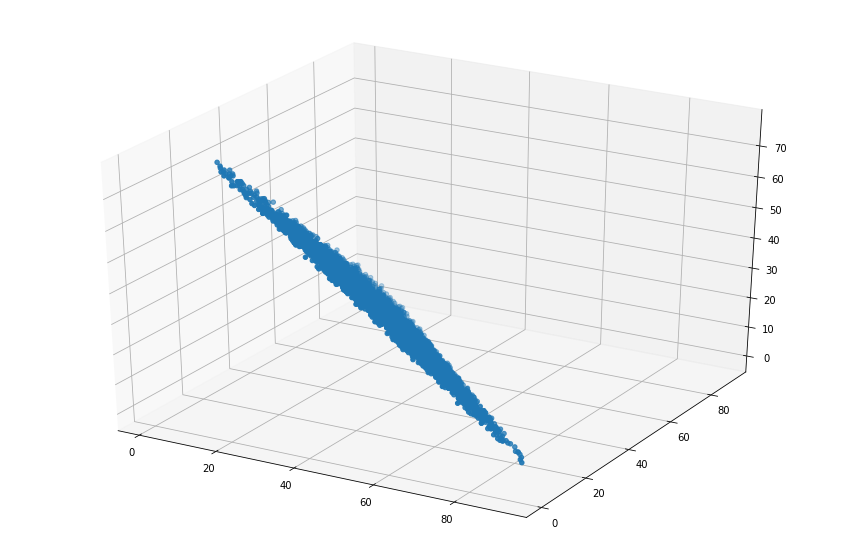

In [14]:
with pd.HDFStore(path + 'X0a_ffh.h5') as store:
    opd = store.select('dat_0')
opd.index = opd.index.droplevel(['eps', 'phi', 'ffh', 'test'])
opinions = opd.xs(level=1, key='opinions')
dfN = opinions
dfN_vis = pd.DataFrame(index=dfN.index)
dfN_vis['x'] = dfN['O1'] + dfN['O2'] + dfN['O3']
dfN_vis['y'] = dfN['O4'] + dfN['O5'] + dfN['O6']
dfN_vis['z'] = dfN['O7'] + dfN['O8']

fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs=dfN_vis[['x']], ys=dfN_vis[['y']], zs=dfN_vis['z'])
dfN.head()